In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf

from pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using Theano backend.


# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
df = pd.read_csv("creditcard.csv")

# Exploration

In [3]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

0    284315
1       492
Name: Class, dtype: int64


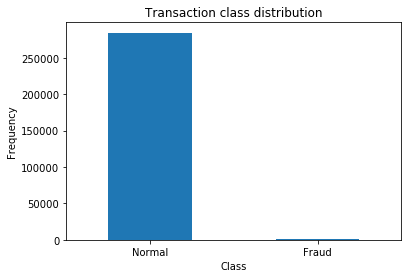

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
print(count_classes)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [6]:
from sklearn.preprocessing import StandardScaler
print(df.shape)
data = df.drop(['Time'], axis=1)
print(data.shape)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
# df[1:]

(284807, 31)
(284807, 30)


Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [7]:
from sklearn.model_selection import train_test_split

data = np.array(data)

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
# print(X_train.shape)
X_train = X_train[X_train[:,-1] == 0]
# print(X_train.shape)
X_train = X_train[:,:-1]
# print(X_train.shape)

y_test = X_test[:,-1]
X_test = X_test[:,:-1]

In [8]:
X_train.shape


(227451L, 29L)

# Building the model

Building an autoencoder with 100 hidden layer neurons.

In [9]:
input_dim = X_train.shape[1]
print(input_dim)
encoding_dim = 15

29


In [10]:
autoencoder = Sequential()

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(20, activation='sigmoid'))
autoencoder.add(Dense(encoding_dim, activation='relu'))
autoencoder.add(Dense(20, activation='sigmoid'))
autoencoder.add(Dense(input_dim, activation='linear'))

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file.

In [13]:
epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mse'])

history = autoencoder.fit(X_train, X_train,
                    nb_epoch = epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 5s - loss: 0.2424 - mean_squared_error: 0.2424 - val_loss: 0.1892 - val_mean_squared_error: 0.1892
Epoch 2/100
227451/227451 [==============================] - 5s - loss: 0.2431 - mean_squared_error: 0.2431 - val_loss: 0.1964 - val_mean_squared_error: 0.1964
Epoch 3/100
227451/227451 [==============================] - 4s - loss: 0.2415 - mean_squared_error: 0.2415 - val_loss: 0.1964 - val_mean_squared_error: 0.1964
Epoch 4/100
227451/227451 [==============================] - 4s - loss: 0.2411 - mean_squared_error: 0.2411 - val_loss: 0.1965 - val_mean_squared_error: 0.1965
Epoch 5/100
227451/227451 [==============================] - 5s - loss: 0.2415 - mean_squared_error: 0.2415 - val_loss: 0.1907 - val_mean_squared_error: 0.1907
Epoch 6/100
227451/227451 [==============================] - 5s - loss: 0.2410 - mean_squared_error: 0.2410 - val_loss: 0.1874 - val_mean_squared_err

227451/227451 [==============================] - 5s - loss: 0.2406 - mean_squared_error: 0.2406 - val_loss: 0.1904 - val_mean_squared_error: 0.1904
Epoch 52/100
227451/227451 [==============================] - 5s - loss: 0.2416 - mean_squared_error: 0.2416 - val_loss: 0.1929 - val_mean_squared_error: 0.1929
Epoch 53/100
227451/227451 [==============================] - 4s - loss: 0.2415 - mean_squared_error: 0.2415 - val_loss: 0.1890 - val_mean_squared_error: 0.1890
Epoch 54/100
227451/227451 [==============================] - 5s - loss: 0.2413 - mean_squared_error: 0.2413 - val_loss: 0.1884 - val_mean_squared_error: 0.1884
Epoch 55/100
227451/227451 [==============================] - 5s - loss: 0.2416 - mean_squared_error: 0.2416 - val_loss: 0.1856 - val_mean_squared_error: 0.1856
Epoch 56/100
227451/227451 [==============================] - 4s - loss: 0.2417 - mean_squared_error: 0.2417 - val_loss: 0.1865 - val_mean_squared_error: 0.1865
Epoch 57/100
227451/227451 [===================

# Evaluation

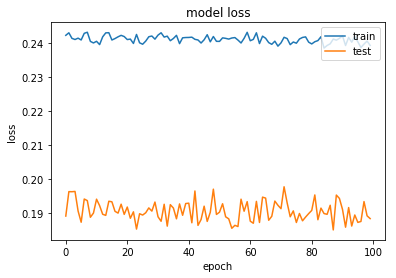

In [15]:
plt.plot(history['mean_squared_error'])
plt.plot(history['val_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [16]:
predictions = autoencoder.predict(X_train)
recon  = (((predictions-X_train)**2).mean(-1))

test_pred = autoencoder.predict(X_test)
test_recon  = (((test_pred-X_test)**2).mean(-1))

mean_recon = recon.mean()

In [ ]:
from sklearn.metrics import precision_score,recall_score

prc = list()
rec = list()
thres = list()

th = 0
for i in range(100):
    th+=0.1
    fraud = (test_recon>mean_recon+th)
    prc.append(precision_score(y_test,fraud))
    rec.append(recall_score(y_test,fraud))
    thres.append(th)
    

In [ ]:
plt.plot(prc, rec)
plt.title('precision vs recall')
plt.ylabel('recall')
plt.xlabel('precision')

In [ ]:
plt.plot(thres, rec)
plt.title('threshold vs recall')
plt.ylabel('recall')
plt.xlabel('threshold')

In [ ]:
plt.plot(thres, prc)
plt.title('threshold vs precision')
plt.ylabel('precision')
plt.xlabel('threshold')